In [2]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

# Use Low Rank completion from pylop and pyproximal 
import pylops
import pyproximal 

2024-07-23 11:23:48.674196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/cupy/_environment.py:438: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate 

In [3]:
# Load the data from the dataset 
dataset_dir = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_10_1000_40.0_10000.pkl'

dataset_list, param_dict = load_dataset(dataset_dir)

In [4]:
template_list = dataset_list[0]['template_chain_list']
X = dataset_list[0]['observation_list']
label_list = dataset_list[0]['labels']

observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
templates_flatten = [squareform(pdist(x)).flatten() for x in template_list]

# Generate random walk for guessing structures
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates

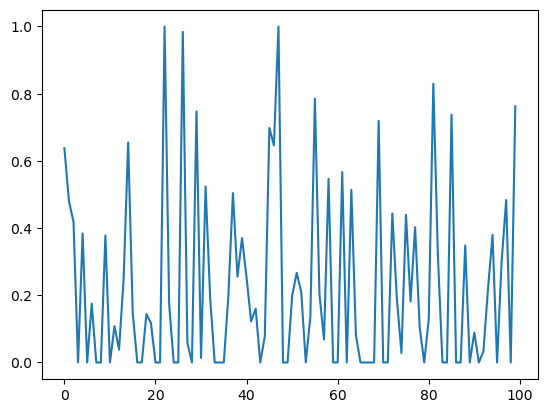

In [5]:
# Introducing missing data to the dataset at specific barcodes with some probabiliity between [0, 1]
missing_data_prob = np.random.normal(0.1, 0.5, num_monomers)
missing_data_prob[missing_data_prob < 0] = 0
missing_data_prob[missing_data_prob > 1] = 1
plt.plot(missing_data_prob)

# Get shuffle indices for shuffling dataset 
shuffle_indices = np.arange(num_observations)
np.random.shuffle(shuffle_indices)

observations_with_nan = np.array([squareform(pdist(x)) for x in X])
observations_with_nan = observations_with_nan[shuffle_indices, :, :]
existing_data = np.zeros(observations_with_nan.shape)
# Randomly add nan to the dataset based on the missing_data_prob
for i in range(num_observations):
    missing_indices = np.random.uniform(size=num_monomers) < missing_data_prob
    observations_with_nan[i, missing_indices, :] = 0
    observations_with_nan[i, :, missing_indices] = 0
    existing_data[i, ~missing_indices, :] = 1
    existing_data[i, :, ~missing_indices] = 1
    
existing_data_flatten = np.array([x.flatten() for x in existing_data.astype(bool)])
observations_flatten = np.array([squareform(pdist(x)) for x in X])[shuffle_indices, :, :]
observations_flatten = np.array([x.flatten() for x in observations_flatten])
observations_flatten_with_nan = np.array([x.flatten() for x in observations_with_nan])

In [74]:
from jaxopt._src.projection import projection_l1_sphere

def projection_nuclear_l1_ball(x: jnp.ndarray, hyperparams_prox) -> jnp.ndarray:
    dim1 = 10000
    dim2 = 100
    max_value = 1
    
    m = jnp.reshape(x, (dim1, dim2))
    l1_norm = jax.numpy.linalg.norm(m, ord='nuc')
    return jax.lax.cond(l1_norm <= max_value,
                        lambda _: x,
                        lambda _: projection_l1_sphere(x, max_value),
                        operand=None)

In [75]:
def matrix_completion_L1_nuclear(optimized_map, distance_map, existing_indices):
    optimized_map = jnp.array(optimized_map).ravel()
    distance_map = jnp.array(distance_map).ravel()
    existing_indices = jnp.array(existing_indices)
    
    optimized_map_selected = jnp.where(existing_indices, optimized_map, 0)
    distance_map_selected = jnp.where(existing_indices, distance_map, 0)
    
    residuals = distance_map_selected - optimized_map_selected
    
    return 0.5 * jnp.linalg.norm(residuals, ord=2)**2

In [8]:
barcode_id = 0
map_nan = observations_flatten_with_nan[:, num_probes*barcode_id:num_probes*(barcode_id+1)]
map = observations_flatten[:, num_probes*barcode_id:num_probes*(barcode_id+1)]
existing_indices = existing_data_flatten[:, num_probes*barcode_id:num_probes*(barcode_id+1)].ravel()

In [9]:
matrix_completion_L1_nuclear(map, map_nan, existing_indices)

Array(3.25581792e+11, dtype=float64)

In [13]:
jax.numpy.linalg.norm(map, ord='nuc')

Array(1563679.70019987, dtype=float64)

In [10]:
from jaxopt.prox import make_prox_from_projection
from jaxopt import ProximalGradient

In [76]:
pg = ProximalGradient(matrix_completion_L1_nuclear, 
                      prox=make_prox_from_projection(projection_nuclear_l1_ball),
                      verbose=True)

In [77]:
pg_sol = pg.run(jnp.zeros_like(map_nan).ravel(), hyperparams_prox=None, distance_map=map_nan, existing_indices=existing_indices,)

INFO: jaxopt.ProximalGradient: Iter: 1 Distance btw Iterates (stop. crit.): 0.5 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 2 Distance btw Iterates (stop. crit.): 0.0 Stepsize:4.0 


In [73]:
pg_sol.params.reshape(10000, 100).sum()

Array(999999.99999999, dtype=float64)

In [66]:
map_nan.sum()

258051877.957389